# SHAP Model Interpretation

In [79]:
import sys
sys.path.append("/home/leest/ml_drought")
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('/DataDrive200/data/')

In [80]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [81]:
EXPERIMENT =      'one_month_forecast'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'
# TARGET_VAR =      'VCI3M'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

/DataDrive200/data/models/one_month_forecast


In [82]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [83]:
# Mask the data
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

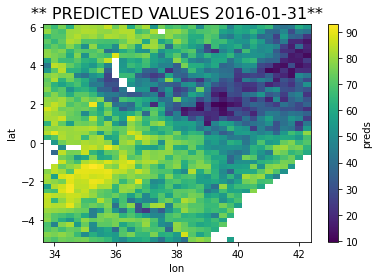

In [84]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

In [85]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT

In [86]:
print(dir(ealstm))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_concatenate_data', '_convert_delta_to_raw_values', '_get_background', '_get_morris_explanations', '_get_shap_explanations', '_initialize_model', '_input_to_tuple', '_load_spatial_mask', '_make_analysis_folder', '_make_weights', '_one_hot', 'batch_size', 'clear_nans', 'current_size', 'data_path', 'data_vars', 'denormalize_y', 'dense_features', 'device', 'evaluate', 'experiment', 'explain', 'features_per_month', 'get_dataloader', 'hidden_size', 'ignore_vars', 'include_latlons', 'include_monthly_aggs', 'include_pred_month', 'include_prev_y', 'include_yearly_aggs', 'input_dense', 'load', 'model', 'model_dir', 'model_name', 'models

In [87]:
# ealstm.data_vars

## examine the data

In [88]:
# ealstm_ignore_vars = [v_ for v_ in ealstm.ignore_vars if v_ != "t2m"]

dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

print(dynamic_ds.data_vars)
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

Data variables:
    boku_VCI  (time, lat, lon) float64 82.14 83.13 71.48 ... 29.12 77.78 49.71
    precip    (time, lat, lon) float64 4.625 4.678 4.806 4.71 ... nan nan nan
    e         (time, lat, lon) float64 -0.003227 -0.002337 -0.002842 ... nan nan
    pev       (time, lat, lon) float64 -0.005993 -0.006077 -0.005873 ... nan nan
    swvl1     (time, lat, lon) float64 0.3288 0.2993 0.334 ... nan nan nan
    swvl2     (time, lat, lon) float64 0.3176 0.3011 0.3329 ... nan nan nan
    swvl3     (time, lat, lon) float64 0.2988 0.2804 0.2896 ... nan nan nan
    swvl4     (time, lat, lon) float64 0.2902 0.2633 0.2777 ... nan nan nan


16

In [89]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 23


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 -5.0 -4.75 ... 6.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables: (12/23)
    precip_global_mean                          (lat, lon) float64 ...
    e_global_mean                               (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    swvl1_global_mean                           (lat, lon) float64 ...
    swvl2_global_mean                           (lat, lon) float64 ...
    swvl3_global_mean                           (lat, lon) float64 ...
    ...                                          ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...

# Run the Shap Analysis

- Run the `scripts/experiments/22_shap_analysis.py` file
- `ipython --pdb 22_shap_analysis.py`

# Explore the demo data

In [55]:
from pandas.tseries.offsets import MonthEnd
from typing import Dict, List
from collections import namedtuple


def get_timestep_from_date_str(date_str) -> pd.Timestamp:
    return pd.to_datetime(date_str, format="%Y_%m") + MonthEnd()


def open_shap_analysis(model) -> Dict[str, namedtuple]:  # type: ignore
    """Read the data from the SHAP analysis run in the other functions"""
    ShapValues = namedtuple(
        "ShapValues", ["date_str", "target_time", "historical", "pred_month", "static"]
    )

    analysis_dir = model.model_dir / "analysis"
    dirs = [d for d in analysis_dir.iterdir() if len(list(d.glob("*.nc"))) > 0]

    out_dict = {}
    for shap_analysis_dir in dirs:
        shap = ShapValues(
            date_str=shap_analysis_dir.name,
            target_time=get_timestep_from_date_str(shap_analysis_dir.name),
            historical=xr.open_dataset(shap_analysis_dir / "shap_historical_ds.nc"),
            pred_month=xr.open_dataset(shap_analysis_dir / "shap_pred_month.nc"),
            static=xr.open_dataset(shap_analysis_dir / "shap_static.nc"),
        )
        out_dict[shap_analysis_dir.name] = shap

    return out_dict

In [56]:
shap = open_shap_analysis(ealstm)
shap.keys()

dict_keys(['2016_11', '2016_12', '2017_2', '2018_12', '2016_8', '2016_4', '2017_4', '2018_1', '2018_6', '2016_3', '2017_8', '2016_7', '2017_6', '2018_10', '2016_9', '2017_9', '2017_11', '2018_5', '2017_7', '2017_10', '2016_6', '2017_5', '2016_10', '2017_1', '2017_3', '2017_12', '2018_11', '2018_2', '2016_1', '2018_4', '2016_2', '2018_9', '2018_8', '2018_7', '2016_5', '2018_3'])

In [57]:
shap["2016_11"].historical

<xarray.Dataset>
Dimensions:                (lat: 45, lon: 35, time: 3)
Coordinates:
  * lat                    (lat) float64 -5.0 -4.75 -4.5 -4.25 ... 5.5 5.75 6.0
  * lon                    (lon) float64 33.75 34.0 34.25 ... 41.75 42.0 42.25
  * time                   (time) datetime64[ns] 2016-08-31 ... 2016-10-31
Data variables: (12/16)
    boku_VCI               (lat, lon, time) float64 ...
    precip                 (lat, lon, time) float64 ...
    e                      (lat, lon, time) float64 ...
    pev                    (lat, lon, time) float64 ...
    swvl1                  (lat, lon, time) float64 ...
    swvl2                  (lat, lon, time) float64 ...
    ...                     ...
    spatial_mean_e         (lat, lon, time) float64 ...
    spatial_mean_pev       (lat, lon, time) float64 ...
    spatial_mean_swvl1     (lat, lon, time) float64 ...
    spatial_mean_swvl2     (lat, lon, time) float64 ...
    spatial_mean_swvl3     (lat, lon, time) float64 ...
    spatial_mean_swvl4     (lat, lon, time) float64 ...

## Find one

In [58]:
# 1. add target time dimension
shap_t = shap['2018_2']
all_shap = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_shap.append(
        shap_t.historical.expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_shap = xr.concat(all_shap, dim='target_time')

In [59]:
# Get only the SHAP values for the previous time
# 1. add target time dimension
shap_t = shap['2018_2']
all_shap_t3 = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_shap_t3.append(
        shap_t.historical.isel(time=-1).expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_shap_t3 = xr.concat(all_shap_t3, dim='target_time')

In [60]:
# Get static data SHAP values
all_static = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_static.append(
        shap_t.static.expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_static = xr.concat(all_static, dim='target_time')

# Get the X Test data (from the input data)

In [61]:
from src.utils import create_shape_aligned_climatology

# create pixel-mean and pixel_std
means = X_train.mean(dim='time').drop([v for v in ealstm.ignore_vars if v in list(X_train.data_vars)])
stds = X_train.std(dim='time').drop([v for v in ealstm.ignore_vars if v in list(X_train.data_vars)])
ones = xr.ones_like(X_test.drop([v for v in ealstm.ignore_vars if v in list(X_train.data_vars)]))
variable='precip'

means = ones*means
stds = ones*stds
# create_shape_aligned_climatology(X_train, means, variable, time_period='month')

x_test = X_test.copy()
x_test = x_test.drop([v for v in ealstm.ignore_vars if v in list(x_test.data_vars)])
norm_x_test = (x_test - means) / stds
norm_x_test

/DataDrive200/data/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DataDrive200/data/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DataDrive200/data/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DataDrive200/data/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/DataDrive200/data/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

<xarray.Dataset>
Dimensions:   (lat: 45, time: 38, lon: 35)
Coordinates:
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2015-10-31 2015-11-30 ... 2018-11-30
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI  (time, lat, lon) float64 -1.744 -0.7433 -1.102 ... 0.9382 -0.3836
    precip    (time, lat, lon) float64 0.3364 0.3544 -0.0631 ... -0.09866 0.2186
    e         (time, lat, lon) float64 0.7824 0.8502 1.052 ... -1.624 -1.817
    pev       (time, lat, lon) float64 -1.319 -1.308 -1.344 ... 1.196 1.263
    swvl1     (time, lat, lon) float64 -0.848 -0.8685 -0.9613 ... 0.9782 1.185
    swvl2     (time, lat, lon) float64 -0.7255 -0.7347 -0.8949 ... 1.058 1.267
    swvl3     (time, lat, lon) float64 0.2431 0.3702 -0.2812 ... 0.2697 0.8201
    swvl4     (time, lat, lon) float64 -1.23 0.993 -0.2535 ... 1.716 2.494

In [62]:
norm_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

# normalize the X data to compare with the shap values
# NEED TO NORMALIZE RELATIVE TO THE PIXEL MEANS ...
list_ds = []
for var in list(x_test.data_vars):
    list_ds.append((
        norm_ds[var] - ealstm.normalizing_dict[var]['mean']
    ) / ealstm.normalizing_dict[var]['std'])
    
    
norm_ds = xr.merge(list_ds)

# get the normalized preds

In [63]:
# set the equivalent times
preds_mean = means[TARGET_VAR].isel(time=slice(0, len(ealstm_pred.time)))
preds_mean['time'] = ealstm_pred.time
preds_std = stds[TARGET_VAR].isel(time=slice(0, len(ealstm_pred.time)))
preds_std['time'] = ealstm_pred.time


norm_pred = (ealstm_pred - preds_mean) / preds_std
norm_pred = norm_pred.compute()

In [64]:
norm_pred = ((ealstm_pred.compute() - ealstm.normalizing_dict['boku_VCI']['mean']) / ealstm.normalizing_dict['boku_VCI']['std'])

# norm_pred

# Explore SHAP Values

In [78]:
shap["2016_5"].historical

<xarray.Dataset>
Dimensions:                (lat: 45, lon: 35, time: 3)
Coordinates:
  * lat                    (lat) float64 -5.0 -4.75 -4.5 -4.25 ... 5.5 5.75 6.0
  * lon                    (lon) float64 33.75 34.0 34.25 ... 41.75 42.0 42.25
  * time                   (time) datetime64[ns] 2016-02-29 ... 2016-04-30
Data variables: (12/16)
    boku_VCI               (lat, lon, time) float64 0.1212 -0.1653 ... -0.31
    precip                 (lat, lon, time) float64 -0.03626 0.0642 ... 0.1081
    e                      (lat, lon, time) float64 -0.04381 -0.1254 ... 0.06059
    pev                    (lat, lon, time) float64 -0.00941 ... 0.04249
    swvl1                  (lat, lon, time) float64 -0.09194 0.009471 ... 0.0232
    swvl2                  (lat, lon, time) float64 -0.02026 ... 0.008855
    ...                     ...
    spatial_mean_e         (lat, lon, time) float64 0.003717 0.02314 ... 0.04482
    spatial_mean_pev       (lat, lon, time) float64 -0.005712 ... 0.02682
    spatial_mean_swvl1     (lat, lon, time) float64 0.005135 ... 0.08576
    spatial_mean_swvl2     (lat, lon, time) float64 -0.0007292 ... 0.07142
    spatial_mean_swvl3     (lat, lon, time) float64 0.0003985 ... -0.01768
    spatial_mean_swvl4     (lat, lon, time) float64 0.008741 ... -0.008118

In [65]:
def plot_shap_obs_pairs(shap_ds: xr.Dataset, obs_ds: xr.Dataset, variables: List[str], shap_plot_kwargs: Dict, obs_plot_kwargs: Dict, norm: bool = False, scale=1) -> None:
    n_variables = len(variables)
    assert np.unique(shap_ds.time.values).shape == (1,), "Only works for a single time"
    fig, axs = plt.subplots(n_variables, 2, figsize=((6*2)*scale, (4*n_variables)*scale))
    
    for ix, variable in enumerate(variables):
        if n_variables > 1:
            ax_row = axs[ix, :]
        else:
            ax_row = axs
        time = pd.to_datetime(
            shap_ds.time.values
        )

        # plot shap values
        shap_ds[variable].plot(ax=ax_row[0], **shap_plot_kwargs)
        ax_row[0].set_title(f"{time._date_repr}: SHAP {variable}")

        # plot the observed data
        obs_ds.sel(time=time)[variable].where(~mask).plot(ax=ax_row[1], **obs_plot_kwargs)
        title = "NORM" if norm else "RAW"
        ax_row[1].set_title(f"{time._date_repr}: {title} {variable}")
        
        for ax in ax_row:
            ax.axis('off')

In [91]:
# shap

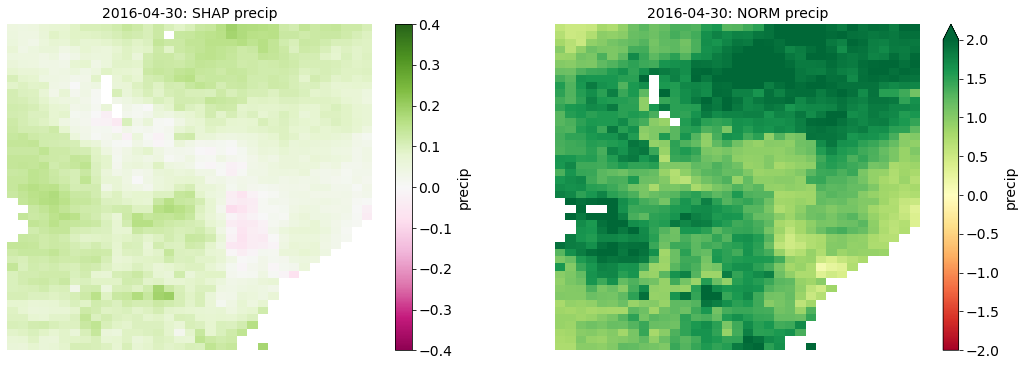

In [66]:
variables = list(ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)]).data_vars)

TIME = '2016_5'

plot_shap_obs_pairs(
    shap[TIME].historical.isel(time=-1), 
    norm_x_test, 
    ["precip"], 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True,
    scale=1.5
)
fig = plt.gcf()

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

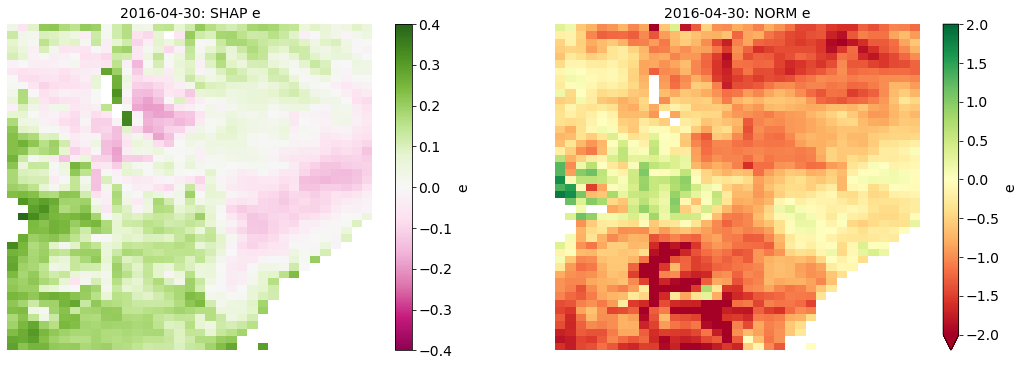

In [67]:
plot_shap_obs_pairs(
    shap[TIME].historical.isel(time=-1), 
    norm_x_test, 
    ["e"], 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True,
    scale=1.5
)
fig = plt.gcf()

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

KeyError: 't2m'

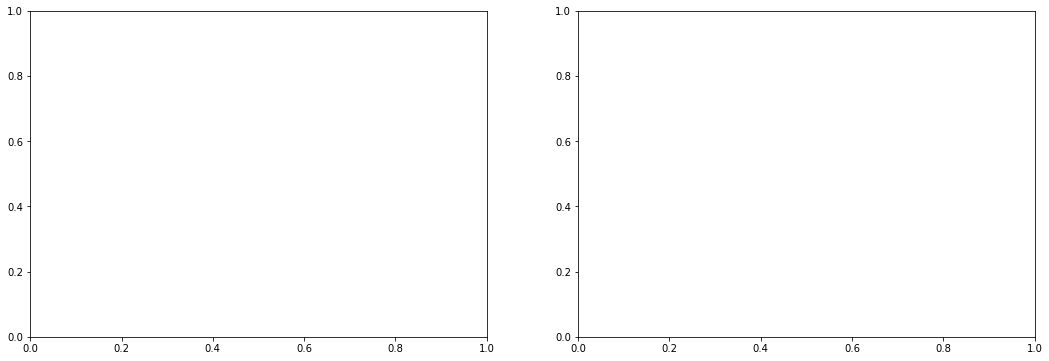

In [68]:
plot_shap_obs_pairs(
    shap[TIME].historical.isel(time=-1), 
    norm_x_test, 
    ["t2m"], 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True,
    scale=1.5
)
fig = plt.gcf()

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

# Show predicted vs. Target

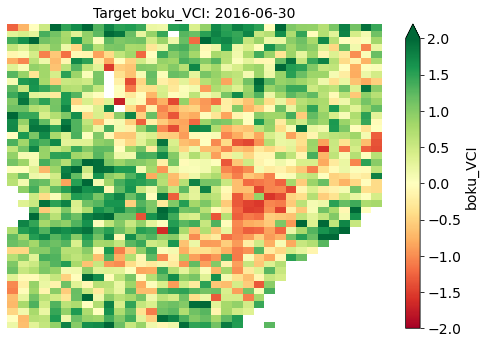

In [92]:
from pandas.tseries.offsets import MonthEnd, DateOffset
target_time = pd.to_datetime(TIME, format="%Y_%m") + MonthEnd() + DateOffset(months=1)
target = norm_ds[TARGET_VAR].sel(time=target_time)
predicted = norm_pred

kwargs = {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}
scale = 1.4
fig, ax = plt.subplots(1, 1, figsize=((6)*scale, (4)*scale))
target.plot(ax=ax, **kwargs)
ax.axis(False)
ax.set_title(f"Target {TARGET_VAR}: {pd.to_datetime(target.time.values)._date_repr}")
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

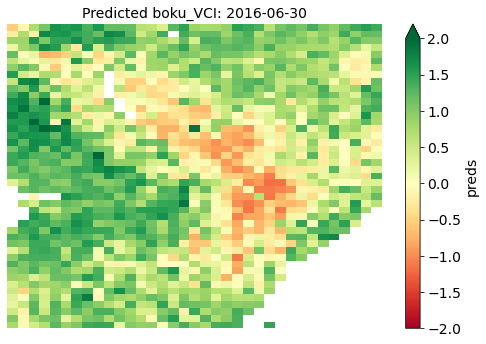

In [93]:
predicted = norm_pred.sel(time=target_time)

kwargs = {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}
scale = 1.4
fig, ax = plt.subplots(1, 1, figsize=((6)*scale, (4)*scale))
predicted.plot(ax=ax, **kwargs)
ax.axis(False)
ax.set_title(f"Predicted {TARGET_VAR}: {pd.to_datetime(target.time.values)._date_repr}")
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)